# Demonstration for DEFRA

Add EODH, CEDA and Oxidian logos! (**TODO**)

__Description & purpose__: This Notebook is designed to showcase the initial functionality of the Earth Observation Data Hub. It provides a snapshot of the Hub, the pyeodh API client and the various datasets as of September 2024. The user has a test site (Thetford) and would like to understand more about the satellite data available for that area. The user is also interested in obtaining a cloud free dataset and creating a data cube. The Notebook is designed in such a way that it can be run on the EODH AppHub (Notebook Service) or from a local environment.  

__Author(s)__: Alastair Graham, Dusan Figala, Phil Kershaw

__Date created__: 2024-09-05

__Date last modified__: 2024-09-18

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

# What is the EODH?
The Earth Observation Data Hub is:

"A UK Pathfinder project delivering access to Earth Observation (EO) data for effective decisionmaking across government, business and academia. The Earth Observation DataHub (EODH) brings together an expert project delivery team and industrial partners in an ambitious project... Users of the Hub will be able to explore areas of interest in the UK and across the globe... It will also enable selected users to support their own analyses, services and tools using the Hub’s workflow and compute environments."

More details can be found online at https://eodatahub.org.uk/

Components of the Hub include:
* A Resource Catalogue - a STAC compliant, (__TO DO__)
* A Workflow Runner
* A Web Presence
* An App Hub  

### Presentation set up

The following cell only needs to be run on the EODH AppHub.  If you have a local Python environment running install the required packages as you would normally.

In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need the following libraries
import sys
!{sys.executable} -m pip install --upgrade pyeodh pandas matplotlib numpy pillow

# EODH: it's data discovery

pyeodh exposes the Hub's API endpoints to Python users

In [2]:
# Imports
import pyeodh

# Workflows
from requests import HTTPError
import os
from pprint import pp

In [4]:
# Connect to the Hub
client = pyeodh.Client().get_catalog_service()

# Print a list of the collections held in the Resource Catalogue (their id and description)
for collect in client.get_collections():
    print(f"{collect.id}: {collect.description}")

cmip6: CMIP6
cordex: CORDEX
ukcp: UKCP
airbus_sar_data: The German TerraSAR-X / TanDEM-X satellite formation and the Spanish PAZ satellite (managed by Hisdesat Servicios Estratégicos S.A.) are being operated in the same orbit tube and feature identical ground swaths and imaging modes - allowing Airbus and Hisdesat to establish a unique commercial Radar Constellation. The satellites carry a high frequency X-band Synthetic Aperture Radar (SAR) sensor in order to acquire datasets ranging from very high-resolution imagery to wide area coverage.
airbus_data_example: Airbus data
airbus_data_example: Airbus data
sentinel2_ard: sentinel 2 ARD
sentinel1: Sentinel 1
naip: The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides U.S.-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR).  NAIP is administered by the [Aerial Field Photography Office](https://www.fsa.usda.gov/p

In [ ]:
# Find some commercial data

In [ ]:
# Find some open data


# EODH: it's mass compute
what are workflows
There's also a QGIS plugin

In [ ]:
# connect to the Workflow Runner

username = os.getenv("ADES_USER")
token = os.getenv("ADES_TOKEN")
s3_token = os.getenv("ADES_S3_TOKEN")

client = pyeodh.Client(username=username, token=token, s3_token=s3_token)
ades = client.get_ades()


In [ ]:
# Workflows

with open('secrets.txt', 'r') as file:
    lines = file.readlines()
    username = lines[0].strip().split('=')[1].strip('"')
    password = lines[1].strip().split('=')[1].strip('"')

client = pyeodh.Client(auth=(username, password))
wfr = client.get_ades()

In [ ]:
# Choose and parameterise a workflow

In [ ]:
# Run the workflow

In [ ]:
# Find the outputs

# EODH: it's data analysis
Notebook service can be used with pyeodh and other libraries installed using pip to analyse data and outputs

In [ ]:
# Create a data cube?

Following 
https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html

**REWORK TO USE EODH IF POSSIBLE**

In [22]:
import dask.distributed
import folium
#import folium.plugins # Not sure what this does
import geopandas as gpd
import shapely.geometry
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load # the data cube bit


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [23]:
# FIND STAC ITEMS

#km2deg = 1.0 / 111
#x, y = (113.887, -25.843)  # Center point of a query
#r = 100 * km2deg
#bbox = (x - r, y - r, x + r, y + r)

url = "https://api.stac.ceda.ac.uk/"

#catalog = Client.open("https://earth-search.aws.element84.com/v1/")
client = Client.open(url)
for coll in client.get_collections():
    print(f"{coll.id}: {coll.description}")

cmip6: CMIP6
cordex: CORDEX
sentinel1: Sentinel 1
sentinel2_ard: sentinel 2 ARD
sst-cdrv3-collection: collection of EOCIS SST CDR V3
ukcp: UKCP


In [24]:
sentinel2_ard = client.get_collection('sentinel2_ard')

sentinel2_ard.get_items()

# check the spatial and temporal extent of the collection

print("spatial extent:", sentinel2_ard.extent.spatial.bboxes)
print("data range:", [str(d) for d in sentinel2_ard.extent.temporal.intervals[0]])



#items = list(query.items())
#print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
#stac_json = query.item_collection_as_dict()

spatial extent: [[-9.00034454651177, 49.48562028352171, 3.1494256015866995, 61.33444247301668]]
data range: ['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']


In [25]:
# SEARCH
item_search = client.search(
    collections=['sentinel2_ard'],
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
    ],
    max_items=100,
)


In [26]:
items = list(item_search.items())
len(items)

100

In [27]:
from shapely import Point
point = Point(-1.3144835766058023, 51.57555380377267) # Atlas building at RAL

item_search = client.search(
    collections=['sentinel2_ard'],
    intersects=point,
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
      ],
    max_items=10,
)

items = list(item_search.items())
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.23.S2A_20230223_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.13.S2A_20230213_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.08.S2B_20230208_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.31.S2A_20230131_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.24.S2A_20230124_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.21.S2A_20230121_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sen

In [28]:
items[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat52lon075_T30UXC_ORB137_utm30n_osgb',
 'properties': {'file_count': 7,
  'start_datetime': '2023-02-25T11:09:39Z',
  'end_datetime': '2023-02-25T11:09:39Z',
  'NSSDC Identifier': '2015-000A',
  'created': '2024-02-07T11:36:30.012295Z',
  'Instrument Family Name': 'Multi-Spectral Instrument',
  'Platform Number': '2B',
  'Datatake Type': 'INS-NOBS',
  'esa_file_name': 'S2B_MSIL1C_20230225T110939_N0509_R137_T30UXC_20230225T115203',
  'Ground Tracking Direction': 'descending',
  'datetime': '2023-02-25T11:09:39Z',
  'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat52lon075_T30UXC_ORB137_utm30n_osgb',
  'size': 1949488461,
  'Product Type': 'S2MSI1C',
  'Instrument Family Name Abbreviation': 'MSI',
  'Start Orbit Number': '031194',
  'eo:cloud_cover': '74.4384424736481',
  'Start Relative Orbit Number': '137',
  'updated': '2024-02-07T11:36:30.0122

In [29]:
item_search = client.search(
    collections=['sentinel2_ard'],
    intersects=point,
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
        'eo:cloud_cover<=50.0'
      ],
    max_items=10,
)

items = list(item_search.items())
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.13.S2A_20230213_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.08.S2B_20230208_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.31.S2A_20230131_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.24.S2A_20230124_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.21.S2A_20230121_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.19.S2B_20230119_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.11.S2A_20230111_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sen

In [30]:
items[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb',
 'properties': {'file_count': 7,
  'start_datetime': '2023-02-20T11:11:01Z',
  'end_datetime': '2023-02-20T11:11:01Z',
  'NSSDC Identifier': '2015-000A',
  'created': '2024-02-07T11:34:51.269363Z',
  'Instrument Family Name': 'Multi-Spectral Instrument',
  'Platform Number': '2A',
  'Datatake Type': 'INS-NOBS',
  'esa_file_name': 'S2A_MSIL1C_20230220T111101_N0509_R137_T30UXC_20230220T131022',
  'Ground Tracking Direction': 'descending',
  'datetime': '2023-02-20T11:11:01Z',
  'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb',
  'size': 2086211720,
  'Product Type': 'S2MSI1C',
  'Instrument Family Name Abbreviation': 'MSI',
  'Start Orbit Number': '040031',
  'eo:cloud_cover': '26.2055898951895',
  'Start Relative Orbit Number': '137',
  'updated': '2024-02-07T11:34:51.2693

In [31]:
for key, value in items[1].assets.items():
    print(key, value.href)

cloud https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_clouds.tif
metadata https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
thumbnail https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg
topographic_shadow https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_toposhad.tif
cog https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
valid_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_valid.tif
saturated_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/s

In [32]:
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.13.S2A_20230213_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.08.S2B_20230208_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.31.S2A_20230131_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.24.S2A_20230124_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.21.S2A_20230121_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.19.S2B_20230119_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.11.S2A_20230111_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sen

In [33]:
# SET UP DASK CLIENT

client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client) # sets up gdal for cloud use
display(client)

/home/al/miniforge3/envs/odc/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36089 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36089/status,
Dashboard: http://127.0.0.1:36089/status,Workers: 4
Total threads: 4,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43071,Workers: 4
Dashboard: http://127.0.0.1:36089/status,Total threads: 4
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:37851,Total threads: 1
Dashboard: http://127.0.0.1:45891/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:44451,


In [34]:
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = item_search.item_collection_as_dict()

Found: 10 datasets


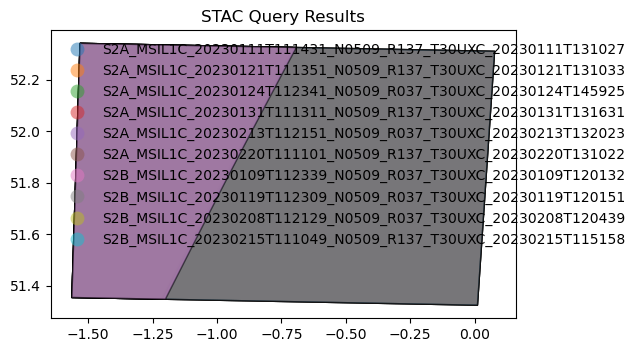

In [35]:
# REVIEW SEARCH RESULTS

gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
#gdf["granule"] = (
#    gdf["esa_file_name"].apply(lambda x: f"{x:02d}")
#    + gdf["mgrs:latitude_band"]
#    + gdf["mgrs:grid_square"]
#)

fig = gdf.plot(
    "esa_file_name",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [36]:
# PLOT THE SAME, but using FOLIUM

# https://github.com/python-visualization/folium/issues/1501
#from branca.element import Figure

import folium
f = folium.Figure(width=600, height=400)
m = folium.Map(location=[52, 2], zoom_start=5).add_to(f)





#fig = Figure(width="400px", height="500px")
#map1 = folium.Map()
#fig.add_child(map1)

#folium.GeoJson(
#    shapely.geometry.box(*bbox),
#    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
#    name="Query",
#).add_to(m)


gdf.explore(
    "esa_file_name",
    categorical=True,
    tooltip=[
        "esa_file_name",
#        "datetime",
#        "eo:cloud_cover",
    ],
    popup=False,
#    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=m,
)

#map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
#display(fig)

In [41]:
# CONSTRUCT DASK DATASET
# Note: there are 9 STAC Items on input, and only one timeslice on output. 
# Due to groupby="solar_day" (all items that occured on the same day added to one image plane).

# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

#xx = stac_load(
#    items,
#    bands=("B04", "B03", "B02"),
#    crs=crs,
#    resolution=10 * zoom)#,
#    chunks={},  # <-- use Dask
#    groupby="solar_day",
#)
#display(xx)


#xx = stac_load(
#    items,
#    chunks={"x": 2048, "y": 2048},
#    patch_url=pc.sign,
#    resolution=resolution,
#    # force dtype and nodata
#    dtype="uint16",
#    nodata=0,
#)

xx = stac_load(
    items,
    crs=crs,
    resolution=10 * zoom,
    chunks={"x": 2048, "y": 2048},  # <-- use Dask
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: cloud,thumbnail,topographic_shadow,cog,valid_pixels,saturated_pixels


<xarray.Dataset> Size: 79MB
Dimensions:             (y: 574, x: 573, time: 10)
Coordinates:
  * y                   (y) float64 5kB 6.862e+06 6.862e+06 ... 6.679e+06
  * x                   (x) float64 5kB -1.742e+05 -1.739e+05 ... 8.8e+03
    spatial_ref         int32 4B 3857
  * time                (time) datetime64[ns] 80B 2023-01-09T11:23:39 ... 202...
Data variables:
    cloud               (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>
    thumbnail           (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>
    topographic_shadow  (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>
    cog                 (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>
    valid_pixels        (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>
    saturated_pixels    (time, y, x) float32 13MB dask.array<chunksize=(1, 574, 573), meta=np.ndarray>

In [ ]:
# DATA FOOTPRINT
#xx.odc.geobox

# TEST
xx.data_vars[cog]

In [ ]:
%%time
xx = xx.compute() # LOAD INTO LOCAL MEMORY